In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
data = pd.read_excel("owid-covid-data.xlsx")
italy_data = data[data['location'] == "Italy"]
italy_data.head(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
146398,ITA,Europe,Italy,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,27.8,NaN,3.18,83.51,0.892,59037472,NaN,NaN,NaN,NaN
146399,ITA,Europe,Italy,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,27.8,NaN,3.18,83.51,0.892,59037472,NaN,NaN,NaN,NaN
146400,ITA,Europe,Italy,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,27.8,NaN,3.18,83.51,0.892,59037472,-1904.1,-12.37,-12.37,-32.00137
146401,ITA,Europe,Italy,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,27.8,NaN,3.18,83.51,0.892,59037472,NaN,NaN,NaN,NaN
146402,ITA,Europe,Italy,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,27.8,NaN,3.18,83.51,0.892,59037472,NaN,NaN,NaN,NaN


## Data Prep

In [59]:
italy_data['date'] = pd.to_datetime(italy_data['date'])
italy_data.columns

/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_58115/2190825487.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  italy_data['date'] = pd.to_datetime(italy_data['date'])


Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [60]:
# drop iso_code, contient, and location as the are not relevant
italy_data = italy_data.drop(['iso_code', 'continent', 'location'], axis=1)
# drop total_cases since it is new_cases accumulated
italy_data = italy_data.drop(['total_cases', 'total_cases_per_million'], axis=1)

In [61]:
# since we are focusing on country level, remove features with more than 30% missingness
missing_percentage = italy_data.isnull().mean() * 100
columns_to_drop = missing_percentage[missing_percentage > 30].index
italy_data.drop(columns=columns_to_drop, inplace=True)
# remove quasi-constant features with more than 98% same values
#Removing quasi-constant features
from sklearn.feature_selection import VarianceThreshold
italy_data_temp = italy_data.select_dtypes(include=[np.number])
sel = VarianceThreshold(threshold=0.02)  
sel.fit(italy_data_temp)  # fit finds the features with low variance
sel_idx = italy_data_temp.columns[sel.get_support()]
print(
    len([
        x for x in italy_data_temp.columns
        if x not in italy_data_temp.columns[sel.get_support()]
    ]))
[x for x in italy_data_temp.columns if x not in italy_data_temp.columns[sel.get_support()]]
italy_data_temp = sel.transform(italy_data_temp)
italy_data_temp = pd.DataFrame(italy_data_temp, columns=sel_idx)
italy_data_temp['date'] = italy_data['date']
italy_data_temp.shape

14


(1357, 32)

In [62]:
italy_data = italy_data_temp
italy_data.columns

Index(['new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million',
       'reproduction_rate', 'icu_patients', 'icu_patients_per_million',
       'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hundred',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred', 'stringency_index',
       'date'],
      dtype='object')

In [63]:
#test train split 
train=italy_data.iloc[:-200 ]
test=italy_data.iloc[-200: ]
print(train.shape, test.shape)

(1157, 32) (200, 32)


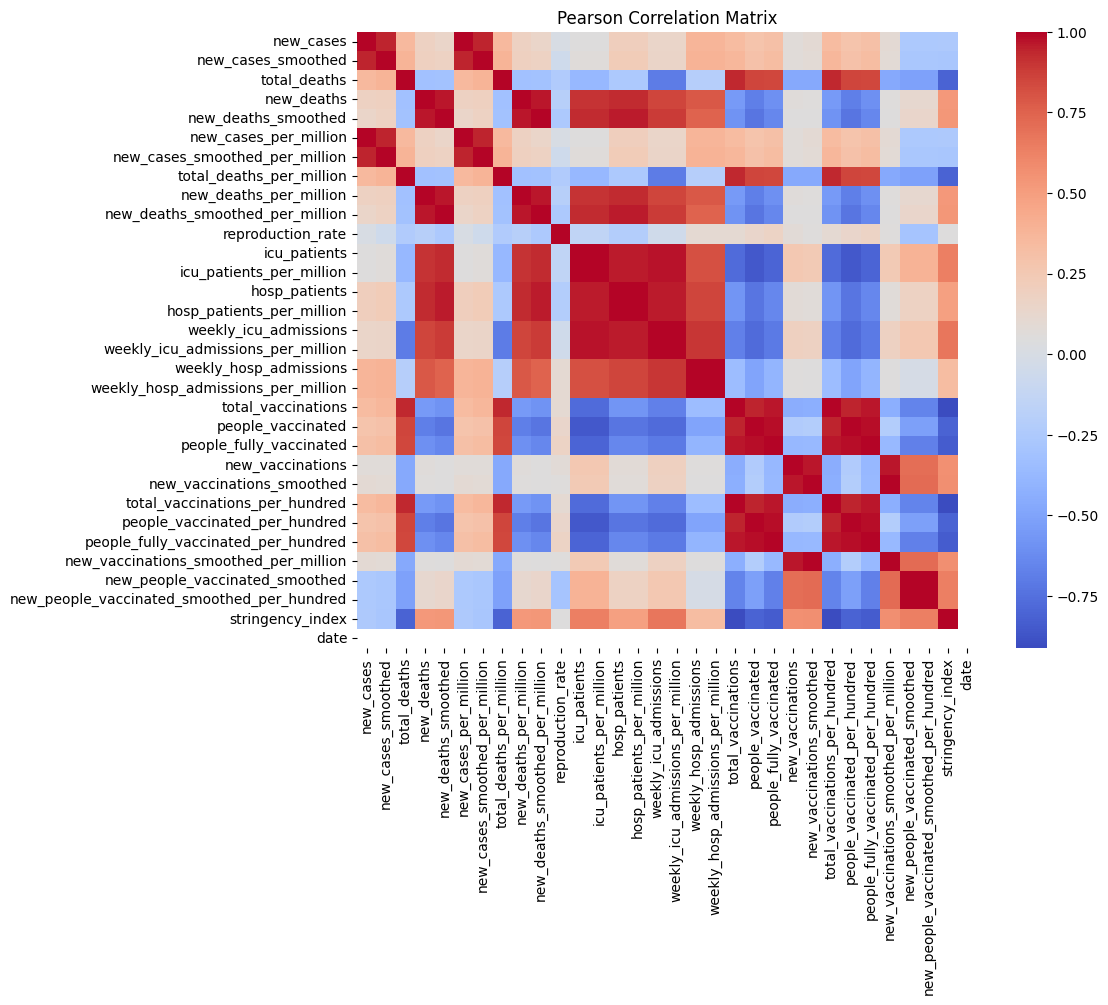

In [64]:
# use Pearson and Spearman correaltion matrix to determine multicollinearity 
pearson_corr = train.corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(pearson_corr,fmt=".2f", cmap='coolwarm')
plt.title('Pearson Correlation Matrix')
plt.show()

In [65]:
train.columns

Index(['new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million',
       'reproduction_rate', 'icu_patients', 'icu_patients_per_million',
       'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hundred',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred', 'stringency_index',
       'date'],
      dtype='object')

In [66]:
# multicollinearity comes from per_hundred, per_million
train = train.loc[:, ~train.columns.str.contains('per_hundred|per_million|total|smoothed')]
train.columns


Index(['new_cases', 'new_deaths', 'reproduction_rate', 'icu_patients',
       'hosp_patients', 'weekly_icu_admissions', 'weekly_hosp_admissions',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'stringency_index', 'date'],
      dtype='object')

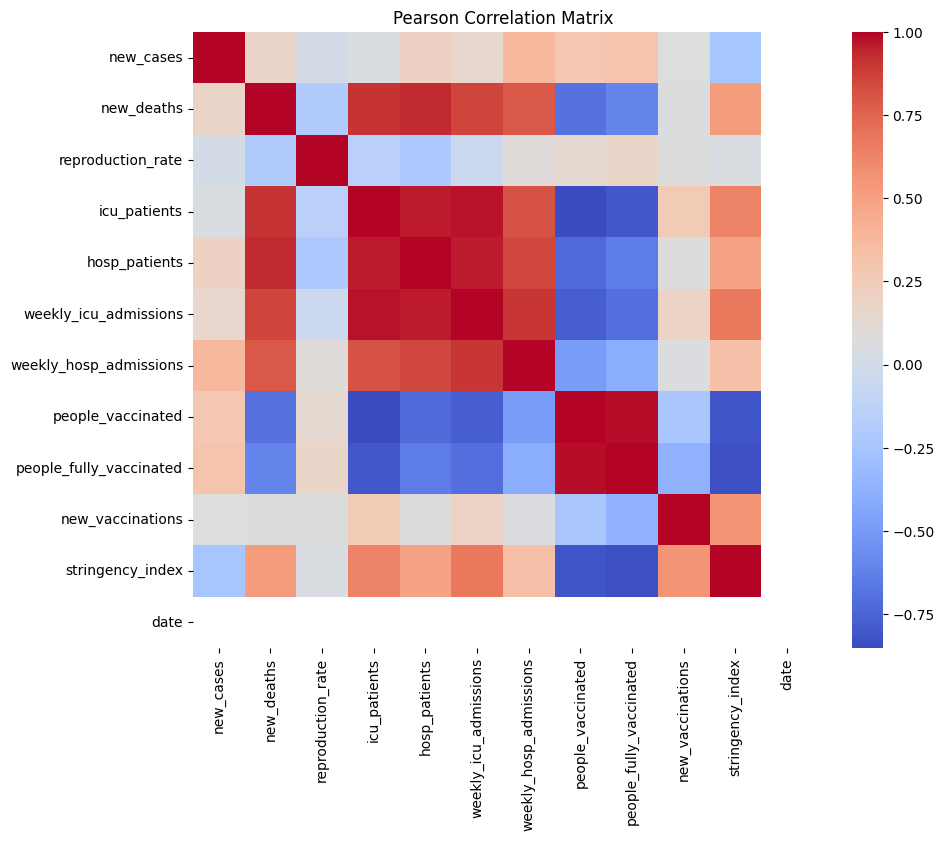

In [68]:
pearson_corr = train.corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(pearson_corr,fmt=".2f", cmap='coolwarm')
plt.title('Pearson Correlation Matrix')
plt.show()

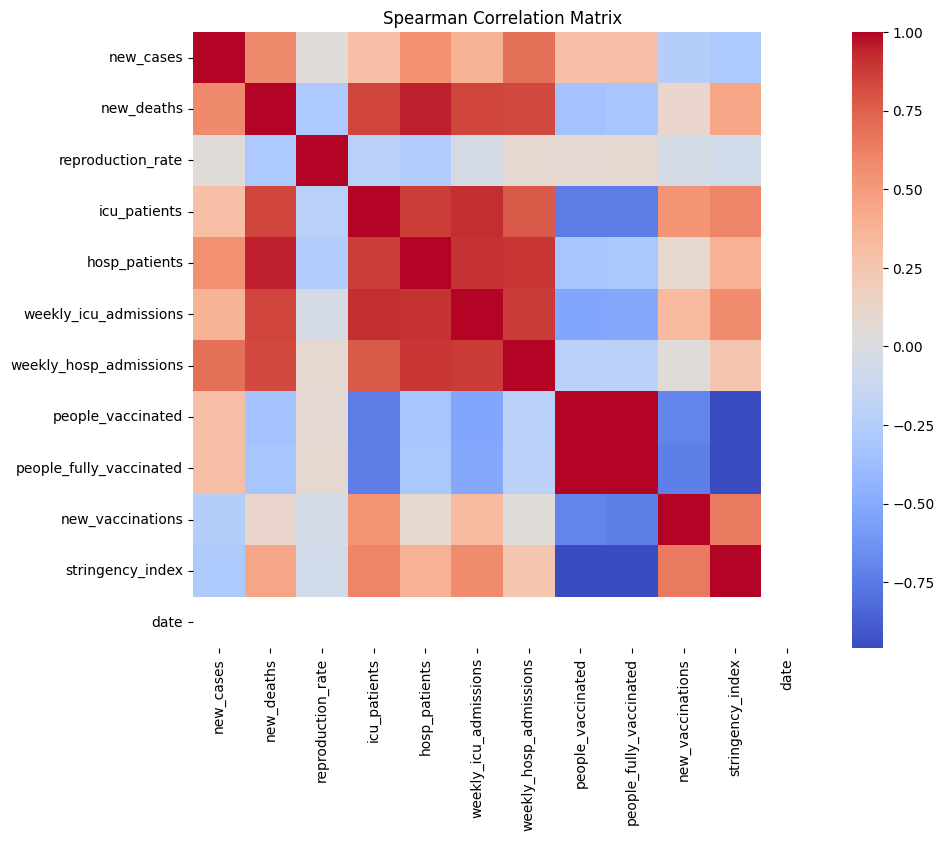

In [67]:
spearman_corr = train.corr(method='spearman')

plt.figure(figsize=(10,8))
sns.heatmap(spearman_corr, fmt=".2f", cmap='coolwarm')
plt.title('Spearman Correlation Matrix')
plt.show()

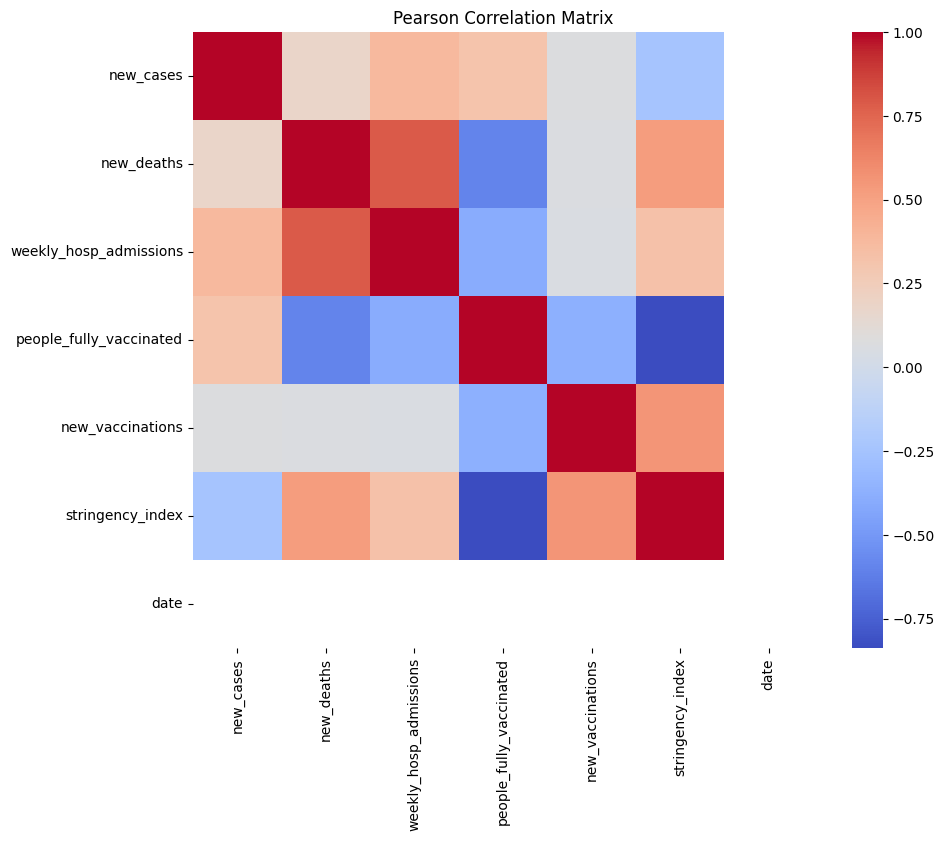

In [69]:
train = train.drop(['weekly_icu_admissions', 'hosp_patients', 'icu_patients', 'people_vaccinated',
                    'reproduction_rate'], axis=1)
pearson_corr = train.corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(pearson_corr,fmt=".2f", cmap='coolwarm')
plt.title('Pearson Correlation Matrix')
plt.show()

In [71]:
train = train.drop(['new_vaccinations'], axis=1)
train = train.drop(['stringency_index'], axis=1)

In [72]:
train.columns

Index(['new_cases', 'new_deaths', 'weekly_hosp_admissions',
       'people_fully_vaccinated', 'date'],
      dtype='object')

In [73]:
test = test.loc[:, ~test.columns.str.contains('per_hundred|per_million|total|smoothed')]
test = test.drop(['weekly_icu_admissions', 'hosp_patients', 'icu_patients', 'people_vaccinated',
                    'reproduction_rate', 'new_vaccinations', 'stringency_index'], axis=1)
test.columns

Index(['new_cases', 'new_deaths', 'weekly_hosp_admissions',
       'people_fully_vaccinated', 'date'],
      dtype='object')

In [74]:
train.rename(columns={'date': 'ds', 'new_cases': 'y'}, inplace=True)
test.rename(columns={'date': 'ds', 'new_cases': 'y'}, inplace=True)

## Feature Engineering

In [76]:
# lagged features with new_cases
for lag in [1, 7, 14]:
    train[f'y_lag{lag}'] = train['y'].shift(lag)
for lag in [1, 7, 14]:
    test[f'y_lag{lag}'] = test['y'].shift(lag)
# rolling window 7-day and 14-day for new_cases
for window in [7, 14]:
    train[f'y_roll_mean{window}'] = train['y'].rolling(window=window).mean()
    train[f'y_roll_std{window}'] = train['y'].rolling(window=window).std()    
for window in [7, 14]:
    test[f'y_roll_mean{window}'] = test['y'].rolling(window=window).mean()
    test[f'y_roll_std{window}'] = test['y'].rolling(window=window).std()

In [77]:
# take into account holiday and incubation period
from prophet.make_holidays import make_holidays_df

us_holidays = make_holidays_df(
    year_list=[2020 + i for i in range(4)], country='US'
)
# italy had two lockdowns
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-09', 'lower_window': 0, 'ds_upper': '2020-05-18'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-09', 'lower_window': 0, 'ds_upper': '2021-02-07'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
holidays = pd.concat((lockdowns, us_holidays))
holidays = holidays.reset_index()
holidays.loc[2:, 'ds_upper'] = holidays.loc[2:, 'ds'] + pd.Timedelta(days=7)
holidays.head()

/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


,index,holiday,ds,lower_window,ds_upper,upper_window
0,0,lockdown_1,2020-03-09,0.0,2020-05-18,70.0
1,1,lockdown_2,2020-11-09,0.0,2021-02-07,90.0
2,0,Martin Luther King Jr. Day,2020-01-20,NaN,2020-01-27,NaN
3,1,Washington's Birthday,2020-02-17,NaN,2020-02-24,NaN
4,2,Columbus Day,2020-10-12,NaN,2020-10-19,NaN
